In [1]:
import torch
from board import move
from board import create_action_mask
import torch.nn as nn
from torch.distributions.categorical import Categorical
import sys
from model import BoardGFLowNet
from board import random_board, get_reward, move, create_action_mask
import wandb

def sample_move(boards: torch.Tensor, 
                logits: torch.Tensor,
                temperature: float, 
                at_step_limit: bool):
    
    batch_size, _, _ = boards.shape
    last_logits = logits[:, -1, :]
    
    if(at_step_limit):
        mask = torch.ones(6) * -1e20
        mask[1] = 0
        mask = mask.expand((batch_size, 6))
    else:
        mask = create_action_mask(boards)
    
    last_logits_with_temp = torch.softmax((mask + last_logits) * temperature, dim=1)
    last_logits = torch.softmax(mask + last_logits, dim=1)
    new_moves = Categorical(probs=last_logits_with_temp).sample()
    new_moves = torch.Tensor(new_moves).type(torch.LongTensor)
    return new_moves, last_logits[torch.arange(batch_size), new_moves]


/home/andrew/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
lr=1e-4
decoder_layers=3
encoder_layers=3
embed_dim=32
d_ff=32
n_heads=8
batch_size=128
side_len=3
max_steps=20
total_batches=1000
checkpoint_freq=10
gfn = BoardGFLowNet(side_len, embed_dim, d_ff, n_heads, encoder_layers, decoder_layers, 6)

In [3]:
gfn.load_state_dict(torch.load('checkpoints beta=20/model_step_119.pt'))
gfn.eval()


BoardGFLowNet(
  (transformer): BoardTransformer(
    (embedding): Embedding(6, 32)
    (board_embedding): Embedding(9, 32)
    (pe): PositionalEncoding()
    (encoder): Encoder(
      (encoders): ModuleList(
        (0): EncoderLayer(
          (mha): MultiheadAttention(
            (heads): ModuleList(
              (0): SelfAttention(
                (Wq): Linear(in_features=32, out_features=32, bias=True)
                (Wk): Linear(in_features=32, out_features=32, bias=True)
                (Wv): Linear(in_features=32, out_features=32, bias=True)
              )
              (1): SelfAttention(
                (Wq): Linear(in_features=32, out_features=32, bias=True)
                (Wk): Linear(in_features=32, out_features=32, bias=True)
                (Wv): Linear(in_features=32, out_features=32, bias=True)
              )
              (2): SelfAttention(
                (Wq): Linear(in_features=32, out_features=32, bias=True)
                (Wk): Linear(in_features=32, out_

In [8]:
'''
def sample_move(boards: torch.Tensor, 
                logits: torch.Tensor, 
                at_step_limit: bool):
    
    batch_size, _, _ = boards.shape
    last_logits = logits[:, -1, :]
    
    if(at_step_limit):
        mask = torch.ones(6) * -1e20
        mask[1] = 0
        mask = mask.expand((batch_size, 6))
    else:
        mask = create_action_mask(boards)
    
    last_logits = torch.softmax(mask + last_logits, dim=1)
    new_moves = Categorical(probs=last_logits).sample()
    new_moves = torch.Tensor(new_moves).type(torch.LongTensor)
    return new_moves, last_logits[torch.arange(batch_size), new_moves]'''

'\ndef sample_move(boards: torch.Tensor, \n                logits: torch.Tensor, \n                at_step_limit: bool):\n    \n    batch_size, _, _ = boards.shape\n    last_logits = logits[:, -1, :]\n    \n    if(at_step_limit):\n        mask = torch.ones(6) * -1e20\n        mask[1] = 0\n        mask = mask.expand((batch_size, 6))\n    else:\n        mask = create_action_mask(boards)\n    \n    last_logits = torch.softmax(mask + last_logits, dim=1)\n    new_moves = Categorical(probs=last_logits).sample()\n    new_moves = torch.Tensor(new_moves).type(torch.LongTensor)\n    return new_moves, last_logits[torch.arange(batch_size), new_moves]'

In [107]:

def loss_fn(predicted_logZ: torch.Tensor, 
            reward: torch.Tensor, 
            forward_probabilities: torch.Tensor):
    
    log_Pf = torch.log(forward_probabilities).sum(dim=1)
    inner = predicted_logZ.squeeze() + log_Pf - torch.log(reward) 
    return inner ** 2

In [108]:
class BoardTransformer(nn.Module):
    def __init__(self, side_len, d_embed, d_ff, n_heads, n_encoders, n_decoders, vocab_size):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, d_embed)
        self.board_embedding = nn.Embedding(side_len**2, d_embed)
        self.pe = PositionalEncoding(d_embed)
        self.encoder = Encoder(d_embed, d_ff, n_heads, n_encoders)
        self.decoder = Decoder(d_embed, d_ff, n_heads, n_decoders)
        self.linear = nn.Linear(d_embed, vocab_size)

    def forward(self, board, move_seq):
        board = board.flatten(start_dim=1)
        board_embs = self.pe(self.board_embedding(board))
        encoder_out = self.encoder(board_embs)
        decoder_emb = self.pe(self.embedding(move_seq))
        decoder_out = self.decoder(decoder_emb, encoder_out)
        prelogits = self.linear(decoder_out)
        return encoder_out, prelogits    

In [124]:

class BoardMLP(nn.Module):
    def __init__(self, side_len, d_embed, max_steps=20, dropout=0.1):
        super().__init__()
        self.board_embedding = nn.Embedding(side_len**2, d_embed)
        self.move_embedding = nn.Embedding(max_steps, d_embed)
        entry_size = (side_len ** 2 + 1) * d_embed   
        self.MLP = nn.Sequential(
            nn.Linear(entry_size, entry_size),
            nn.Dropout(dropout),
            nn.ELU(),
            nn.Linear(entry_size, entry_size),
            nn.Dropout(dropout),
            nn.ELU(),
            nn.Linear(entry_size, entry_size),
            nn.Dropout(dropout),
            nn.ELU(),
            nn.Linear(entry_size, entry_size),
            nn.Dropout(dropout),
            nn.ELU(),
            nn.Linear(entry_size, entry_size),
            nn.Dropout(dropout),
            nn.ELU(),
            nn.Linear(entry_size, entry_size),
            nn.Dropout(dropout),
            nn.ELU(),
            nn.Linear(entry_size, entry_size),
            nn.Dropout(dropout),
            nn.ELU(),
            nn.Linear(entry_size, entry_size),
            nn.Dropout(dropout),
            nn.ELU(),
            nn.Linear(entry_size, 6),
        )
        
    def forward(self, 
                board: torch.Tensor, 
                move_num: int
                ): 
        batch_size, _, _ = board.shape
        board = board.flatten(start_dim=1)
        board_embs = self.board_embedding(board)
        board_embs = board_embs.flatten(start_dim=1)
        move_num_embed = self.move_embedding(torch.LongTensor([move_num]))
        move_num_embed = move_num_embed.expand((batch_size, -1)) # might lead to issues; if in doubt, try repeat() instead
        
        embs = torch.cat([board_embs, move_num_embed], dim=1)
        embs = self.MLP(embs)
        return board_embs, embs

In [125]:

class BoardGFLowNet2(nn.Module):
    def __init__(self, side_len, d_embed, max_steps=20, dropout=0.1):
        super().__init__()
        self.MLP = BoardMLP(side_len, d_embed, max_steps, dropout)
        self.logz_predictor = nn.Sequential(
            nn.Linear(side_len ** 2 * d_embed, side_len ** 2 * d_embed),
            nn.ELU(),
            nn.Linear(side_len ** 2 * d_embed, side_len ** 2 * d_embed),
            nn.ELU(),
            nn.Linear(side_len ** 2 * d_embed, side_len ** 2 * d_embed),
            nn.ELU(),
            nn.Linear(side_len ** 2 * d_embed, (side_len ** 2 * d_embed) // 2),
            nn.ELU(),
            nn.Linear((side_len ** 2 * d_embed) // 2, (side_len ** 2 * d_embed) // 4),
            nn.ELU(),
            nn.Linear((side_len ** 2 * d_embed) // 4, 1),
            nn.ELU(),   
        )
    
    def forward(self, boards, move_num):
        board_embs, output_embs = self.MLP(boards, move_num)
        logz = self.logz_predictor(board_embs)
        
        return logz, output_embs.unsqueeze(0)


In [126]:
gfn2 = BoardGFLowNet2(side_len, embed_dim, max_steps=20)
total_params = 0
for param in gfn.parameters():
    total_params += param.numel()
print(f'There are {total_params} total parameters.')

There are 326759 total parameters.


In [127]:
sampled_rewards = []
sampled_matchings = []
with torch.no_grad():
    for i in range(1000):
        boards = random_board(batch_size, side_len) 
        finished = torch.zeros((batch_size, 1))
        # moves = torch.zeros(batch_size, 1).type(torch.LongTensor)
        move_num = 0
        forward_probabilities = torch.ones(batch_size, 1)

        predicted_logZ, _ = gfn2(boards, 0)
        batch_loss = 0
        batch_reward = 0
        batch_matching = 0
        
        for i in range(max_steps):
            
            _, logits = gfn2(boards, move_num)
            move_num += 1
            new_move, move_prob = sample_move(boards, logits, 10, i == max_steps-1)
            
            move_prob[torch.where(finished == 1)[0]] = 1
            finished[torch.where(new_move == 1)] = 1

            
            forward_probabilities = torch.cat([forward_probabilities, move_prob.unsqueeze(1)], dim=1)
            # print(moves.shape, new_move.unsqueeze(1).shape)
            # moves = torch.cat([moves, new_move.unsqueeze(1)], dim=1)
            boards = boards.clone()
            boards = move(boards, new_move, finished_mask=finished)
        
        reward, matching = get_reward(boards)
        
        loss = loss_fn(predicted_logZ, reward, forward_probabilities)
        sampled_rewards += reward.tolist()
        sampled_matchings += matching.tolist()
        reward = torch.sum(reward)
        matching = torch.sum(matching)
        batch_reward += reward
        batch_matching += matching
        batch_reward = batch_reward.item() / batch_size
        batch_matching = batch_matching.item() / batch_size
        print('Batch matching:', batch_matching)
        

Batch matching: 1.703125
Batch matching: 1.8125
Batch matching: 1.6484375
Batch matching: 1.7109375
Batch matching: 1.6953125
Batch matching: 1.859375
Batch matching: 1.9765625
Batch matching: 1.7109375
Batch matching: 1.7734375
Batch matching: 1.75
Batch matching: 1.71875
Batch matching: 2.0703125
Batch matching: 1.6640625
Batch matching: 1.828125
Batch matching: 1.671875
Batch matching: 1.859375
Batch matching: 1.6953125
Batch matching: 1.8515625
Batch matching: 1.6484375
Batch matching: 1.5703125
Batch matching: 1.7265625
Batch matching: 1.703125
Batch matching: 1.75
Batch matching: 1.4921875
Batch matching: 1.6875
Batch matching: 1.640625
Batch matching: 1.9453125
Batch matching: 1.5234375
Batch matching: 1.7890625
Batch matching: 1.7265625
Batch matching: 1.7109375
Batch matching: 1.7265625
Batch matching: 1.625
Batch matching: 1.7265625
Batch matching: 1.7890625


KeyboardInterrupt: 

In [6]:
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'Random GFlowNet, sampling temperature=10')

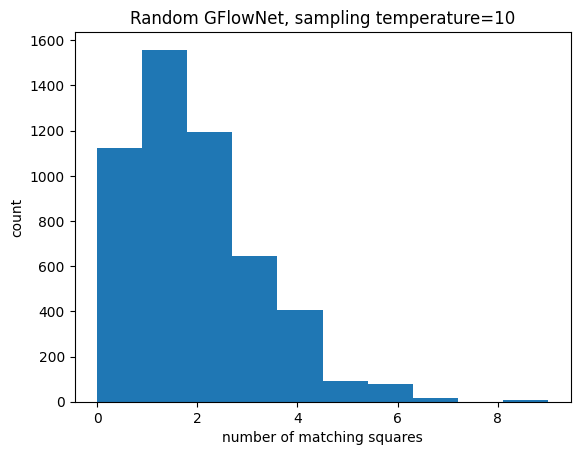

In [30]:
plt.hist(sampled_matchings)

plt.ylabel('count')
plt.xlabel('number of matching squares')
plt.title('Random GFlowNet, sampling temperature=10')

Text(0.5, 1.0, 'Trained GFlowNet (beta=20), sampling temperature=10')

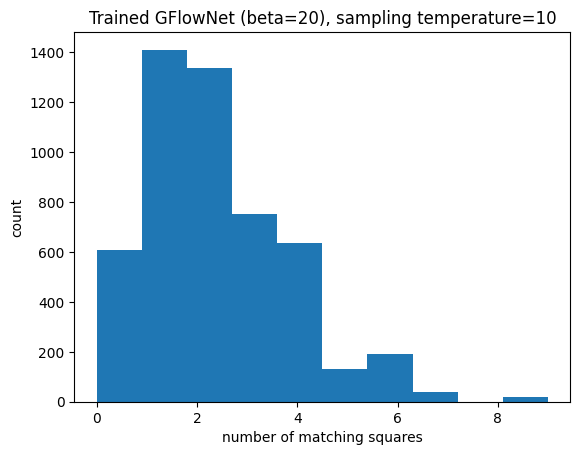

In [28]:
plt.hist(sampled_matchings)

plt.ylabel('count')
plt.xlabel('number of matching squares')
plt.title('Trained GFlowNet (beta=20), sampling temperature=10')

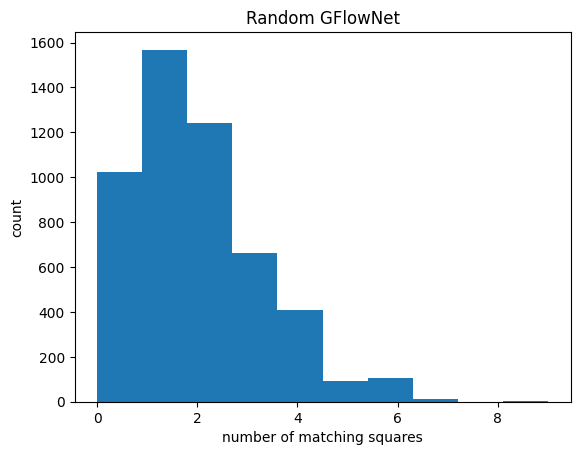

In [14]:
plt.hist(sampled_matchings)

plt.ylabel('count')
plt.xlabel('number of matching squares')
plt.title('Trained GFlowNet')

In [10]:
a = torch.load('sampled_matchings.pt')

Text(0.5, 1.0, 'Trained GFlowNet')

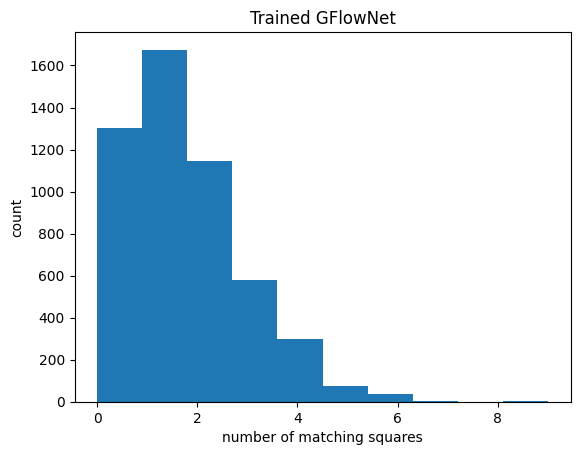

In [13]:
plt.hist(a)
plt.ylabel('count')
plt.xlabel('number of matching squares')
plt.title('Trained GFlowNet')

In [92]:
'''torch.save(sampled_matchings, 'sampled_matchings.pt')
torch.save(sampled_rewards, 'sampled_rewards.pt')'''

"torch.save(sampled_matchings, 'sampled_matchings.pt')\ntorch.save(sampled_rewards, 'sampled_rewards.pt')"